# Proyek Klasifikasi Gambar: rice-image-dataset
- **Nama:** Danny Suggi Saputra
- **Email:** dannysaputra3003@gmail.com

## Import Semua Packages/Library yang Digunakan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
import itertools

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout
from keras.models import Model, Sequential
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import imageio
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as img

import os
import pathlib

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

In [ ]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Data Preparation

### Data Loading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-image-dataset


In [ ]:
import shutil
import os

# Target path di /content
target_path = "/content/rice-image-dataset"

# Salin ke /content (gunakan copytree)
shutil.copytree(path, target_path)

print("Dataset disalin ke:", target_path)

Dataset disalin ke: /content/rice-image-dataset


In [ ]:
import pathlib

dataset_path = "/content/rice-image-dataset/Rice_Image_Dataset"

# Convert dataset_path to a Path object
dataset_path = pathlib.Path(dataset_path)

arborio = list(dataset_path.glob('Arborio/*'))[:1000]
basmati = list(dataset_path.glob('Basmati/*'))[:1000]
ipsala = list(dataset_path.glob('Ipsala/*'))[:1000]
jasmine = list(dataset_path.glob('Jasmine/*'))[:1000]
karacadag = list(dataset_path.glob('Karacadag/*'))[:1000]

In [ ]:
data = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}
rice_labels= {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3:"Jasmine",
    4:"Karacadag"}



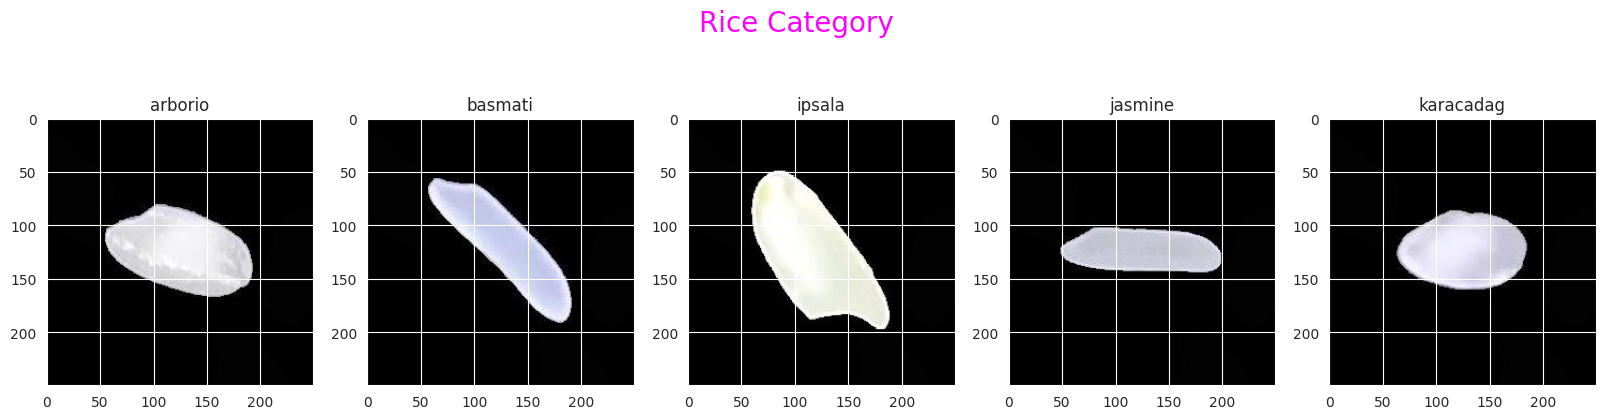

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category',color='magenta',fontsize=20)
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

for index,name in enumerate(list(data.keys())):
    ax[index].set_title(name)
ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)

### Data Preprocessing

#### Split Dataset

In [ ]:
# Buat list semua file gambar beserta label-nya
filepaths = []
labels = []

for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(label)

# Buat dataframe
df = pd.DataFrame({
    'filename': filepaths,
    'class': labels
})

In [ ]:
# Split train (70%) dan temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)

# Split temp jadi val (15%) dan test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print("Train:", len(train_df), "Validation:", len(val_df), "Test:", len(test_df))

Train: 52500 Validation: 11250 Test: 11250


In [ ]:
# Buat ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Buat generator dari dataframe
train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


## Modelling

In [ ]:
cnn=keras.models.Sequential()
cnn.add(keras.layers.Conv2D(filters=32,kernel_size=3,
                            padding='valid',activation='relu',input_shape=(224,224,3)))
cnn.add(keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(40,activation='relu'))
cnn.add(keras.layers.Dropout(rate= 0.1, seed= 100))
cnn.add(keras.layers.Dense(units=5,activation='sigmoid'))

In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │    15,770,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,772,021 (60.17 MB)

 Trainable params: 15,772,021 (60.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

## Evaluasi dan Visualisasi

In [ ]:
cnn.fit(
    train_gen,
    epochs=2,
    validation_data=val_gen,
    shuffle=True
)

Epoch 1/2
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2414s 1s/step - accuracy: 0.9038 - loss: 0.3252 - val_accuracy: 0.9823 - val_loss: 0.0509
Epoch 2/2
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2343s 1s/step - accuracy: 0.9871 - loss: 0.0403 - val_accuracy: 0.9876 - val_loss: 0.0443


In [ ]:
def plot(c):
    plt.plot(c.history.history['accuracy'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_accuracy'],marker='*',color='green',markersize=10)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(c.history.history['loss'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_loss'],marker='*',color='green',markersize=10)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()


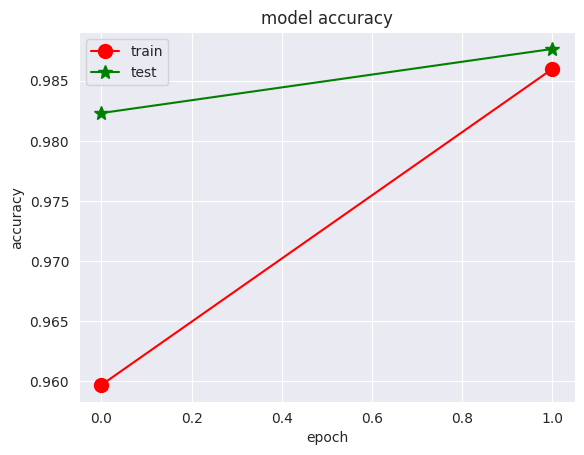

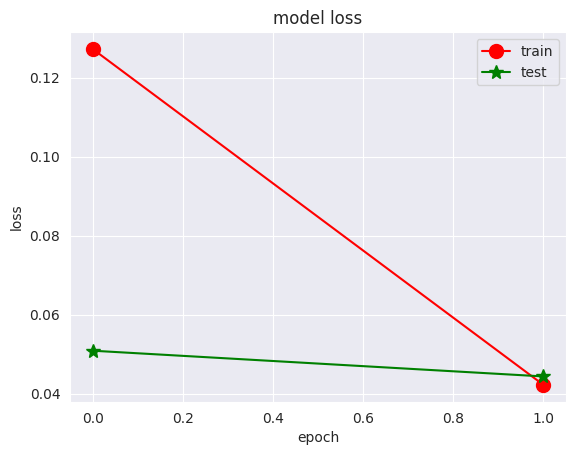

In [ ]:
plot(cnn)

In [ ]:
# Evaluasi akhir pada test set
test_loss, test_accuracy = cnn.evaluate(test_gen)
print(f"\nFinal Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

352/352 ━━━━━━━━━━━━━━━━━━━━ 142s 404ms/step - accuracy: 0.9891 - loss: 0.0387

Final Test Accuracy: 98.91%
Final Test Loss: 0.0396


352/352 ━━━━━━━━━━━━━━━━━━━━ 142s 403ms/step
              precision    recall  f1-score   support

     Arborio       0.99      0.97      0.98      2250
     Basmati       0.99      0.99      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      0.99      0.99      2250
   Karacadag       0.97      1.00      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



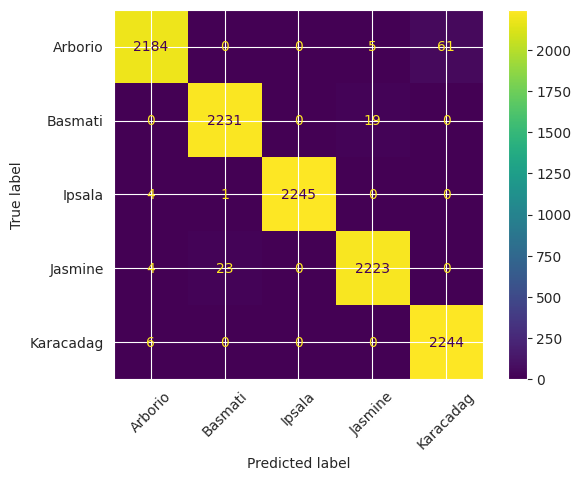

In [ ]:
# Prediksi di test set
pred_probs = cnn.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Laporan klasifikasi
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45)
plt.show()

## Konversi Model

In [ ]:
# SavedModel

save_path = 'mymodel/'
tf.saved_model.save(cnn, save_path)

In [ ]:
# TF Lite

# Load model
loaded = tf.saved_model.load('mymodel/')

# Ambil fungsi default serving
concrete_func = loaded.signatures['serving_default']

# Konversi
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Simpan
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


In [ ]:
# TFJS

!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    mymodel/ tfjs_model/

2025-04-25 02:55:44.951217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745549744.978604   24383 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745549744.987655   24383 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-25 02:55:55.436792: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745549756.170403   24383 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'inputs', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'Identity', 'index': 13, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


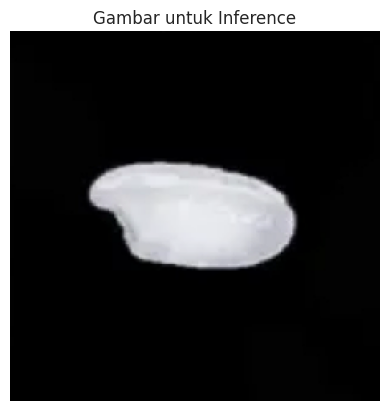

In [ ]:
img_path = "/content/test_arborio_rice.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

plt.imshow(img)
plt.axis(False)
plt.title("Gambar untuk Inference")
plt.show()

In [ ]:
# Set input ke interpreter
interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))

# Jalankan inference
interpreter.invoke()

# Ambil output dari model
output_data = interpreter.get_tensor(output_details[0]['index'])

# Ambil index prediksi (kelas dengan probabilitas tertinggi)
predicted_class = np.argmax(output_data)

# Ambil mapping label → index dari train_gen
label_map = train_gen.class_indices

# Balik mapping jadi index → label
labels = {v: k for k, v in label_map.items()}

# Cetak hasil
print("Output Probabilities:", output_data)
print("Predicted Class Index:", predicted_class)
print("Predicted Label:", labels[predicted_class])

Output Probabilities: [[0.9997752  0.00309406 0.12999417 0.05951818 0.9890628 ]]
Predicted Class Index: 0
Predicted Label: Arborio
